<a href="https://colab.research.google.com/github/HumbertoMezaRuiz/FisicaComputacional1/blob/main/Actividad11/Actividad11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bibliotecas**

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
from numpy import linspace, zeros

%matplotlib inline
plt.style.use('bmh')

# ***Problema 1***

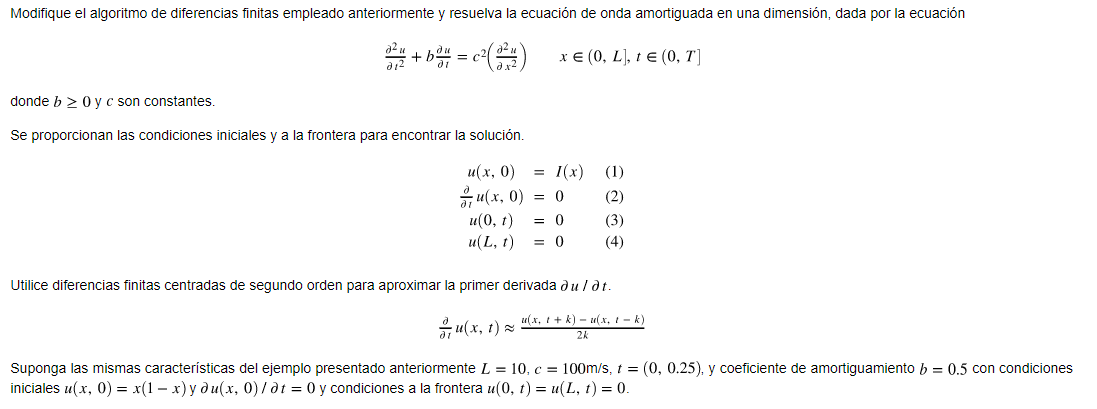

In [41]:
#Usamos el código descrito en clase para la ecuación de onda añadiendo al método el segundo término del lado izquierdo de la ecuación

def solver(I, V, f, c, L, Nx, C, T, user_action=None):
    """Resuelve u_tt=c^2*u_xx + f sobre (0,L)x(0,T]."""
    x = linspace(0, L, Nx+1) # Malla en x
    dx = x[1] - x[0]
    dt = C*dx/c
    Nt = int(round(T/dt))
    t = linspace(0, Nt*dt, Nt+1) # Malla en t
    C2 = C**2 # Simplificar la ecuación
    
    if f is None or f == 0 :
        f = lambda x, t: 0
    
    if V is None or V == 0:
        V = lambda x: 0
    u = zeros(Nx+1) # Solución al nuevo tiempo
    u_1 = zeros(Nx+1) # Solución 1 paso atrás en el tiempo
    u_2 = zeros(Nx+1) # Solución 2 pasos atrás en el tiempo
    
    import time; 
    #t0 = time.clock() # Mediremos el tiempo de CPU
    t0 = time.process_time()

    # Cargar la condición inicial en u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])

    if user_action is not None:
        user_action(u_1, x, t, 0)
    
    # Fórmula del primer paso
    n = 0
    for i in range(1, Nx):
        u[i] = u_1[i] + dt*V(x[i]) + \
        0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) + \
        0.5*dt**2*f(x[i], t[n])
    u[0] = 0; u[Nx] = 0
    
    if user_action is not None:
        user_action(u, x, t, 1)
    
    # Redefinimos variables para volver a utilizar
    u_2[:], u_1[:] = u_1, u
    
    for n in range(1, Nt):
        # Actualiza los valores en el tiempo t[n+1]
        for i in range(1, Nx):
            u[i] = (1/(1/dt**2+0.5/2*dt))*((c**2/dx**2)*(u[i+1]-2*u[i]+u[i-1])+(2*u[i]-u_1[i])/dt**2+(0.5/2*dt)*u_1[i])
        # Definimos la condición a la frontera
        u[0] = 0; u[Nx] = 0

        if user_action is not None:
            if user_action(u, x, t, n+1):
                break

        # Redefinimos variables antes del siguiente paso
        u_2[:], u_1[:] = u_1, u

    # cpu_time = t0 - time.clock()
    cpu_time = time.process_time() - t0
    return u, x, t, cpu_time

def user_action(u, x, t, n):
    "Define una acción del usuario para guardar y visualizar posteriormente los datos."
    global user_data
    if 'x' not in user_data:
        user_data['x'] = x
    if 'u' not in user_data:
        user_data['u'] = [(n, u)]
    else:
        user_data['u'].append((t[n], u.copy()))

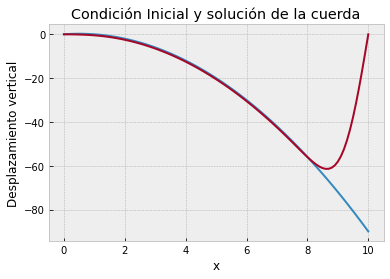

In [42]:
# Ejemplo de una cuerda vibrante L=10, t=(0,0.25), c=100m/s
# Variables solver(I, V, f, c, L, Nx, C, T, user_action=None)
# I = Condición Incial
# V = Velocidad Inicial
# f = función de forzamiento 
# c = Velocidad de propagación
# L = Longitud de la cuerda
# Nx = Núm. de puntos en x
# C = c*k/h Constante de Courant < 1
# T = Tiempo final de Integración

user_data = {}
u, x, t, cpu_time = solver(lambda x: x*(1-x), None, None , 100, 10, 100, 0.1, 0.25, user_action=user_action)

I = x*(1-x)

plt.xlabel('x')
plt.ylabel('Desplazamiento vertical')
plt.title('Condición Inicial y solución de la cuerda')
plt.plot(x,I)
plt.plot(x,u)

In [43]:
# Animación

from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

duration = 20

fig, ax = plt.subplots(figsize=(4, 3), facecolor='white', dpi=92)
plt.tight_layout()

def make_frame_mpl(t):
    n = int(t / duration * (len(user_data['u']) - 1))
    ax.clear()
    x = user_data['x']
    t, u = user_data['u'][n]
    ax.plot(x, u)
    ax.set_title('t = {:.2f}'.format(t))
    ax.set_ylim(-80, 0.25)
    ax.set_xlabel('x (a. u.)')
    ax.set_ylabel('Desplazamiento vertical (a. u.)')
    return mplfig_to_npimage(fig) # imágen de la figura

animation = mpy.VideoClip(make_frame_mpl, duration=duration)
plt.close(fig)
animation.ipython_display(fps=20, width=600)

100%|█████████▉| 400/401 [00:30<00:00, 13.25it/s]


# ***Problema 2***

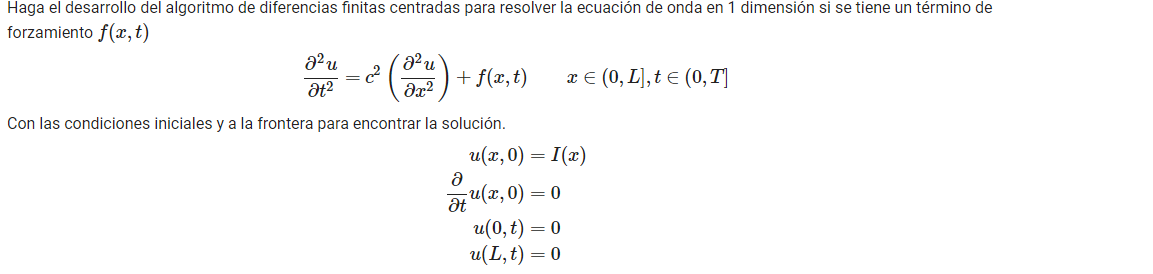

# ***Problema 3***

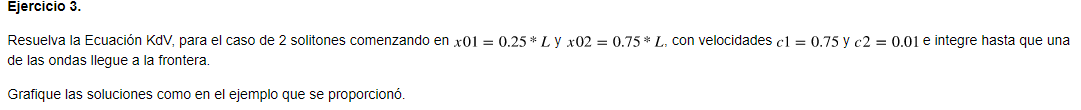

Calculando la solución.
Graficando una representación de la interacción de 2 ondas solitarias.


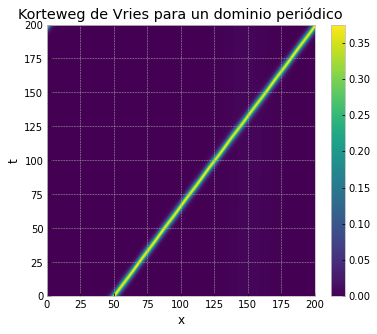

In [44]:
#!python

import numpy as np
from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

def kdv_exact(x, c):
    """Perfil de la solución exacta de la Ecuación KdV: 1 solitón sobre el eje real"""
    u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
    return u

def kdv(u, t, L):
    """Las ecuaciones diferenciales de la ecuación KdV, discretizada en x"""
    # Calcula las derivadas en x usando un método pseudoespectral (Transformada de Fourier)
    # Supone tener condiciones periódicas en la dirección x
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)

    # Calcula el lado derecho de la ecuación de KdV 
    dudt = -6*u*ux - uxxx
    return dudt

def kdv_solution(u0, t, L):
    """Utiliza la función odeint para integrar la ecuación KdV sobre un dominio periódico.
    `u0` es la condición inicial, `t` es el arreglo de tiempos en los que se evaluará la ecuación, 
     y `L` es el tamaño del dominio periódico en x"""

    sol = odeint(kdv, u0, t, args=(L,), mxstep=5000)
    return sol

if __name__ == "__main__":
    # Define el tamaño del dominio y crea una malla discretizada.
    L = 200.0
    # Preferentemente N=potencia de 2^n (exigencia de la transformada rápida de Fourier FFT)
    Nx = 256

    dx = L / (Nx - 1.0) # dx < 0.8
    x = np.linspace(0, (1-1.0/Nx)*L, Nx) # L < N

    # Definir las condiciones iniciales
    # Dos solitones (ondas solitarias) viajando hacia la derecha en un dominio periódico
    # Un soliton a la izquierda del otro. Posicionados en x-x01 y x-x02, 
    # Con velocidades c1 > c2 que provocará que colisionen entre si (el primero alcance al segundo)
    x01 = 0.25*L
    x02 = 0.75*L
    c1= 0.75
    c2= 0.01
    u0 = kdv_exact(x-x01, c1) + kdv_exact(x-x02, c2)
    
    # Definir el tamaño del dominio en el tiempo
    # Tiempo final T
    T = 200
    Nt = 501
    t = np.linspace(0, T, Nt)

    print("Calculando la solución.")
    sol = kdv_solution(u0, t, L)

    print("Graficando una representación de la interacción de 2 ondas solitarias.")

    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,5))
    plt.imshow(sol[::-1, :], extent=[0,L,0,T])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.axis('auto')
    plt.title('Korteweg de Vries para un dominio periódico')
    plt.show()

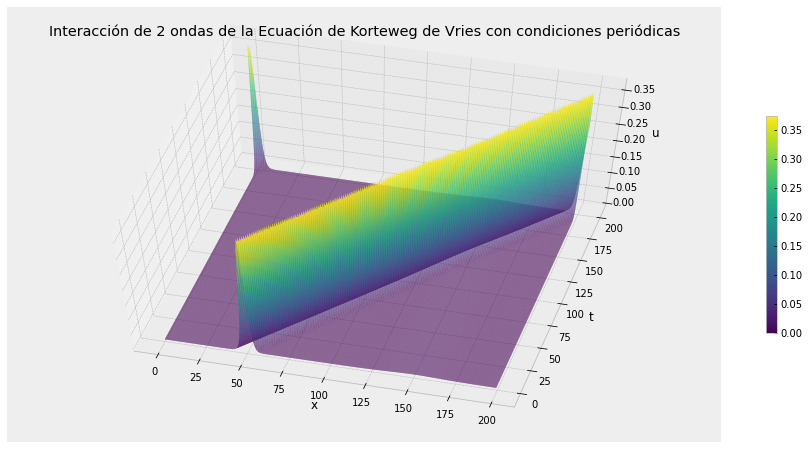

In [45]:
# Gráfica tipo superfices en 3D en evolución

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')

SX, ST = np.meshgrid(x, t)
# Ver mapa de colores de Matplotlib
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
ax.plot_surface(SX, ST, sol, cmap='viridis', rstride=1, cstride=1, alpha=0.75)

# Grafica una tabla de valores 
m = cm.ScalarMappable(cmap='viridis')
m.set_array(sol)
plt.colorbar(m,shrink=0.5)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(elev=60, azim=-75)
ax.set_title('Interacción de 2 ondas de la Ecuación de Korteweg de Vries con condiciones periódicas')
plt.show()

Nótese que hay un ligero cambio en la altura de la "superficie" (el área púrpura) en el lugar donde comienza x02, como c1 es demasiado pequeño apenas y se alcanza a localizar, por ello, en la primera gráfica (en 2D) ni siquiera es perceptible.

# **Problema 4**

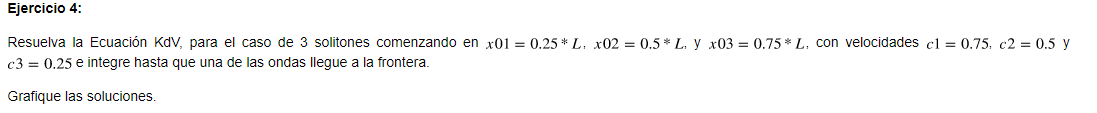

Calculando la solución.
Graficando una representación de la interacción de 2 ondas solitarias.


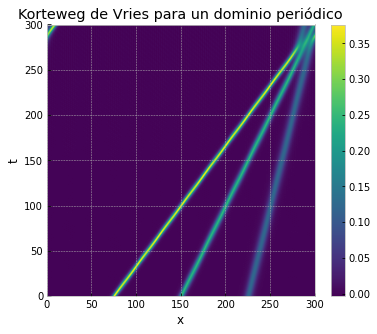

In [46]:
#!python

import numpy as np
from scipy.integrate import odeint
from scipy.fftpack import diff as psdiff
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

def kdv_exact(x, c):
    """Perfil de la solución exacta de la Ecuación KdV: 1 solitón sobre el eje real"""
    u = 0.5*c*np.cosh(0.5*np.sqrt(c)*x)**(-2)
    return u

def kdv(u, t, L):
    """Las ecuaciones diferenciales de la ecuación KdV, discretizada en x"""
    # Calcula las derivadas en x usando un método pseudoespectral (Transformada de Fourier)
    # Supone tener condiciones periódicas en la dirección x
    ux = psdiff(u, period=L)
    uxxx = psdiff(u, period=L, order=3)

    # Calcula el lado derecho de la ecuación de KdV 
    dudt = -6*u*ux - uxxx
    return dudt

def kdv_solution(u0, t, L):
    """Utiliza la función odeint para integrar la ecuación KdV sobre un dominio periódico.
    `u0` es la condición inicial, `t` es el arreglo de tiempos en los que se evaluará la ecuación, 
     y `L` es el tamaño del dominio periódico en x"""

    sol = odeint(kdv, u0, t, args=(L,), mxstep=5000)
    return sol

if __name__ == "__main__":
    # Define el tamaño del dominio y crea una malla discretizada.
    L = 300.0
    # Preferentemente N=potencia de 2^n (exigencia de la transformada rápida de Fourier FFT)
    Nx = 256

    dx = L / (Nx - 1.0) # dx < 0.8
    x = np.linspace(0, (1-1.0/Nx)*L, Nx) # L < N

    # Definir las condiciones iniciales
    # Dos solitones (ondas solitarias) viajando hacia la derecha en un dominio periódico
    # Un soliton a la izquierda del otro. Posicionados en x-x01 y x-x02, 
    # Con velocidades c1 > c2 que provocará que colisionen entre si (el primero alcance al segundo)
    x01 = 0.25*L
    x02 = 0.50*L
    x03 = 0.75*L
    c1= 0.75
    c2= 0.50
    c3= 0.25
    u0 = kdv_exact(x-x01, c1) + kdv_exact(x-x02, c2) + kdv_exact(x-x03, c3)
    
    # Definir el tamaño del dominio en el tiempo
    # Tiempo final T
    T = 300
    Nt = 501
    t = np.linspace(0, T, Nt)

    print("Calculando la solución.")
    sol = kdv_solution(u0, t, L)

    print("Graficando una representación de la interacción de 2 ondas solitarias.")

    import matplotlib.pyplot as plt

    plt.figure(figsize=(6,5))
    plt.imshow(sol[::-1, :], extent=[0,L,0,T])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.axis('auto')
    plt.title('Korteweg de Vries para un dominio periódico')
    plt.show()

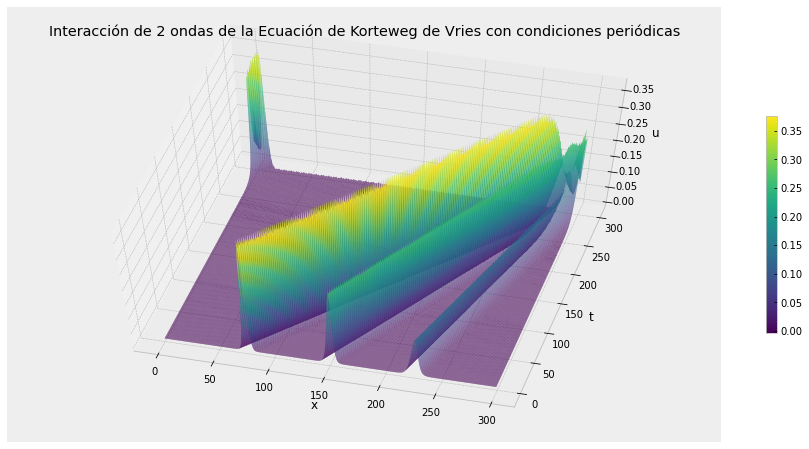

In [47]:
# Gráfica tipo superfices en 3D en evolución

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111, projection='3d')

SX, ST = np.meshgrid(x, t)
# Ver mapa de colores de Matplotlib
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
ax.plot_surface(SX, ST, sol, cmap='viridis', rstride=1, cstride=1, alpha=0.75)

# Grafica una tabla de valores 
m = cm.ScalarMappable(cmap='viridis')
m.set_array(sol)
plt.colorbar(m,shrink=0.5)

ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
ax.view_init(elev=60, azim=-75)
ax.set_title('Interacción de 2 ondas de la Ecuación de Korteweg de Vries con condiciones periódicas')
plt.show()

# **Problema 5**

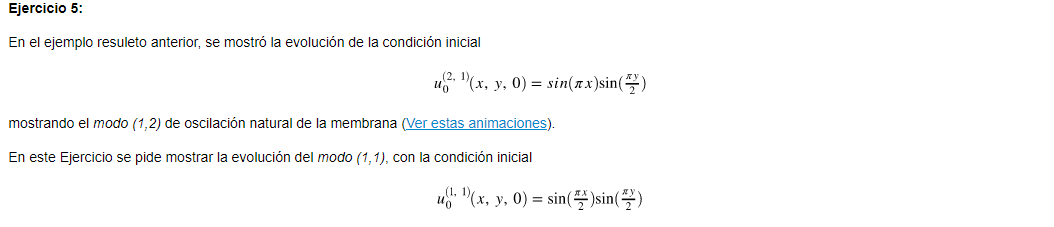

N: 200
D: 0.25
Mx: 50
My 50
dx,dy; 0.04 0.04
nsteps: 200


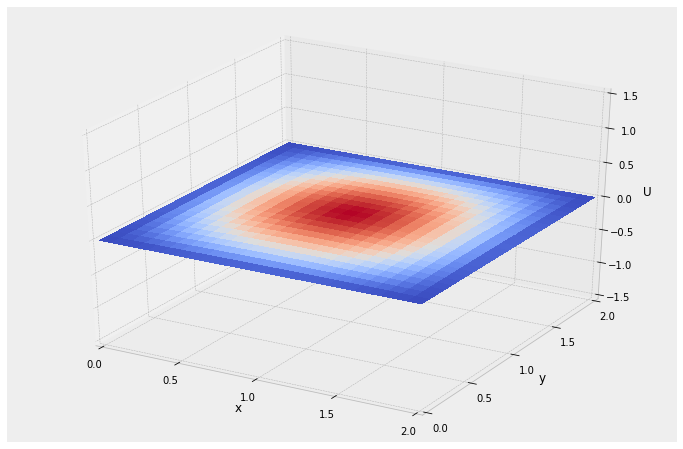

paso: 10.0 t= 0.285


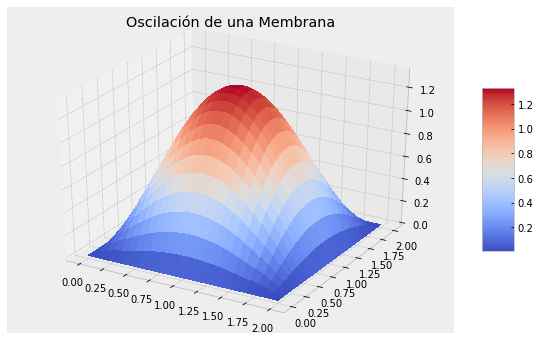

paso: 20.0 t= 0.585


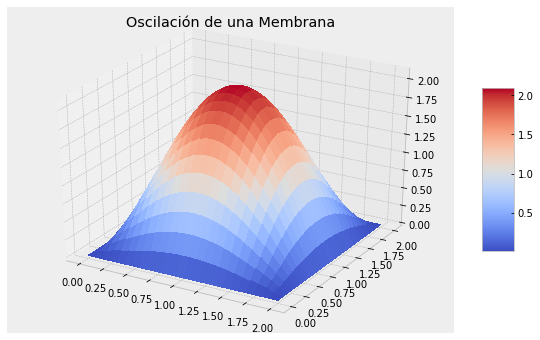

paso: 30.0 t= 0.885


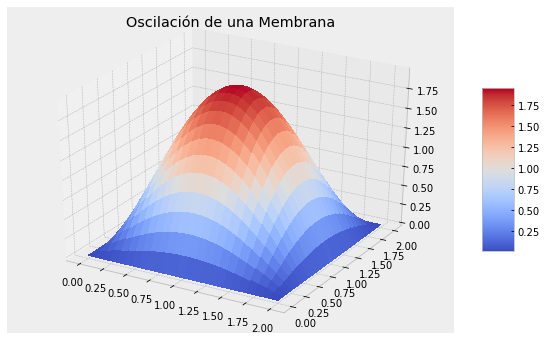

paso: 40.0 t= 1.185


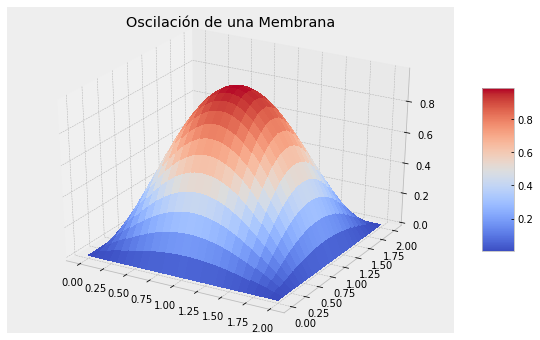

paso: 50.0 t= 1.4849999999999999


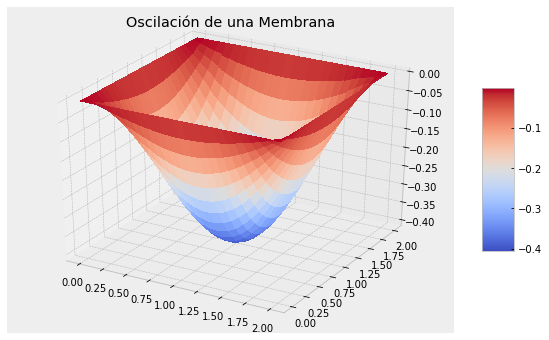

paso: 60.0 t= 1.785


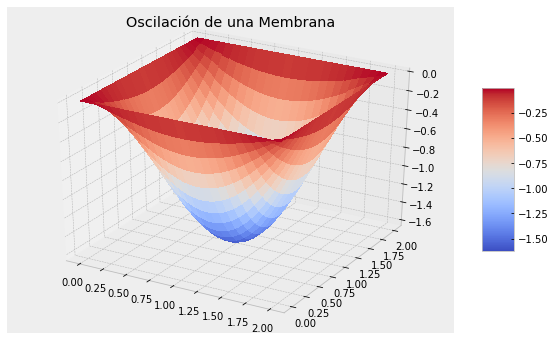

paso: 70.0 t= 2.085


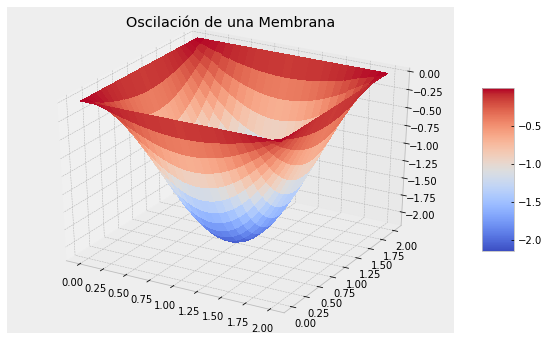

paso: 80.0 t= 2.385


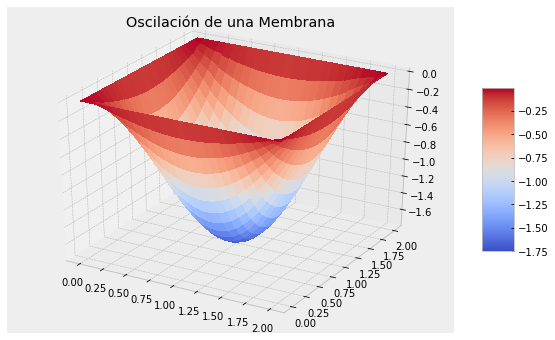

paso: 90.0 t= 2.685


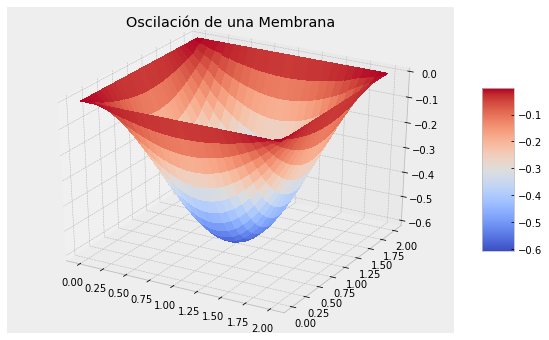

paso: 100.0 t= 2.985


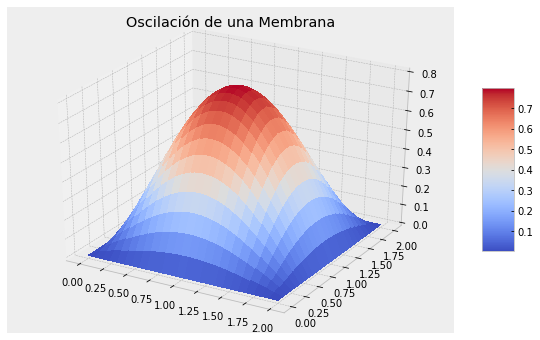

In [48]:
#!python 
#Solución de la Ecuación de Onda en 2D: Utt = (Uxx+Uyy)
# Método de Diferencias Finitas 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# Se define la Clase general que incluye todas las funciones
class WaveEquationFD:
    
    def __init__(self, N, D, Mx, My):
        self.N = N
        print('N:',N)
        self.D = D
        print('D:',D)
        self.Mx = Mx
        print('Mx:',Mx)
        self.My = My
        print('My',My)
        self.tend = 6
        self.xmin = 0
        self.xmax = 2
        self.ymin = 0
        self.ymax = 2
        self.initialization()
        self.eqnApprox()
           
    def initialization(self):
        self.dx = (self.xmax - self.xmin)/self.Mx
        self.dy = (self.ymax - self.ymin)/self.My
        print('dx,dy;',self.dx,self.dy)
        
        self.x = np.arange(self.xmin, self.xmax+self.dx, self.dx)
        self.y = np.arange(self.ymin, self.ymax+self.dy, self.dy)
        
        #----- Initial condition -----#
        self.u0 = lambda r, s: 0.1*np.sin(np.pi*r/2)*np.sin(np.pi*s/2)
        
        #----- Initial velocity -----#
        self.v0 = lambda a, b: 0
        
        #----- Boundary conditions -----#
        self.bxyt = lambda left, right, time: 0
        
        self.dt = (self.tend - 0)/self.N
        self.t = np.arange(0, self.tend+self.dt/2, self.dt)
        
        # Assertion for the condition of r < 1, for stability
        r = 4*self.D*self.dt**2/(self.dx**2+self.dy**2);
        assert r < 1, "r is bigger than 1!"

            
    def eqnApprox(self):
        #----- Approximation equation properties -----#
        self.rx = self.D*self.dt**2/self.dx**2
        self.ry = self.D*self.dt**2/self.dy**2
        self.rxy1 = 1 - self.rx - self.ry 
        self.rxy2 = self.rxy1*2

        #----- Initialization matrix u for solution -----#
        self.u = np.zeros((self.Mx+1, self.My+1))
        self.ut = np.zeros((self.Mx+1, self.My+1))
        self.u_1 = self.u.copy()
        
        #----- Fills initial condition and initial velocity -----#
        for j in range(1, self.Mx):
            for i in range(1, self.My):
                self.u[i,j] = self.u0(self.x[i], self.y[j])
                self.ut[i,j] = self.v0(self.x[i], self.y[j])
        
    
    def solve_and_animate(self):
        
        u_2 = np.zeros((self.Mx+1, self.My+1))
        
        xx, yy = np.meshgrid(self.x, self.y)
         
        fig = plt.figure(figsize=(12,8))        
        ax = fig.add_subplot(111, projection='3d')
        #ax = plt.axes(projection ='3d')
        
        wframe = None
        
        k = 0
        nsteps = self.N
        print('nsteps:',nsteps)
        
        while k < nsteps:
            if wframe:
                ax.collections.remove(wframe)
                
            self.t = k*self.dt
            
            #----- Fills in boundary condition along y-axis (vertical, columns 0 and Mx) -----#
            for i in range(self.My+1):
                self.u[i, 0] = self.bxyt(self.x[0], self.y[i], self.t)
                self.u[i, self.Mx] = self.bxyt(self.x[self.Mx], self.y[i], self.t)
                
            for j in range(self.Mx+1):
                self.u[0, j] = self.bxyt(self.x[j], self.y[0], self.t)
                self.u[self.My, j] = self.bxyt(self.x[j], self.y[self.My], self.t)
                
            if k == 0:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = 0.5*(self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j])) \
                                + 0.5*(self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1])) \
                                + self.rxy1*self.u[i,j] + self.dt*self.ut[i,j]
            else:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j]) \
                            + self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1]) \
                            + self.rxy2*self.u[i,j] - u_2[i,j]
                            
            u_2 = self.u_1.copy()
            self.u_1 = self.u.copy()

            wframe = ax.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
            
            ax.set_xlim3d(0, 2.0)
            ax.set_ylim3d(0, 2.0)
            ax.set_zlim3d(-1.5, 1.5)
            
            ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0])
            ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
            
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("U")
            
            plt.pause(0.05)
            k += 0.5
            
            # Sección añadida para hacer gráficas cada 15 pasos 
            if (k < 101 and k%10 == 0):
                print('paso:',k, 't=', self.t)
                # Creating figure
                fig2 = plt.figure(figsize =(10, 6))
                ax2 = plt.axes(projection ='3d')
                # Creating color map
                my_cmap = plt.get_cmap('coolwarm')
                # Creating plot
                surf = ax2.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
                fig.colorbar(surf, ax = ax2,
                    shrink = 0.5, aspect = 5)
                ax2.set_title('Oscilación de una Membrana')
                # show plot
                plt.show()

# Se definen los parámetros con los que se va a ejecutar el código     
# N pasos de integración, parámetro de estabilidad < 0.5, Num.Puntos x, Núm.Puntos y

def main():
    simulator = WaveEquationFD(200, 0.25, 50, 50)
    simulator.solve_and_animate() # No funcionó en Google Colab
    plt.show()
    
if __name__ == "__main__":
    main()

# **Problema 6**

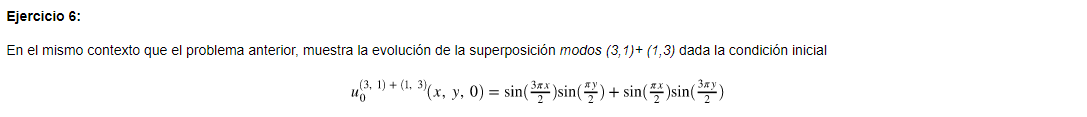

N: 200
D: 0.25
Mx: 50
My 50
dx,dy; 0.04 0.04
nsteps: 200


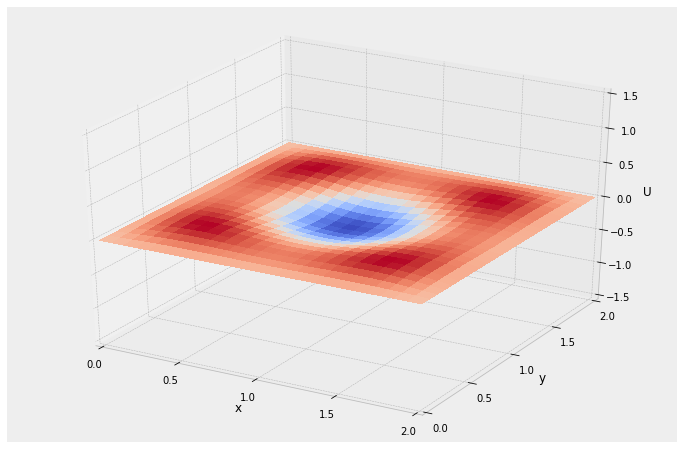

paso: 10.0 t= 0.285


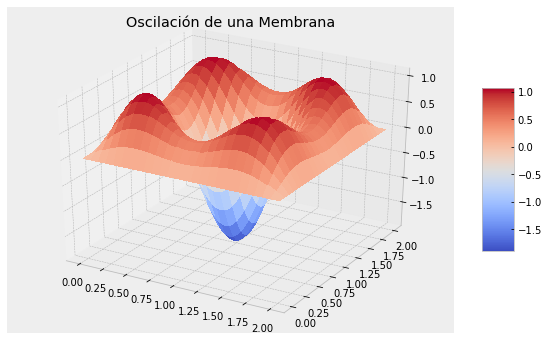

paso: 20.0 t= 0.585


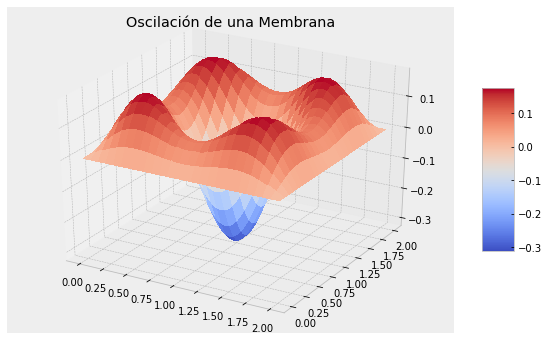

paso: 30.0 t= 0.885


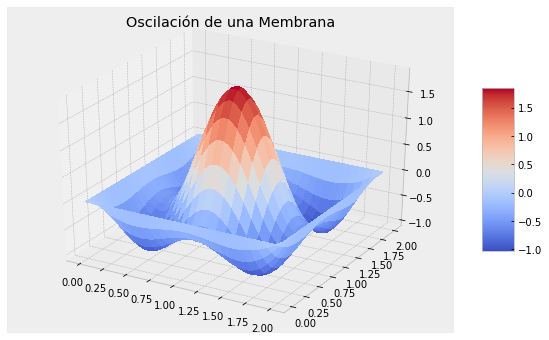

paso: 40.0 t= 1.185


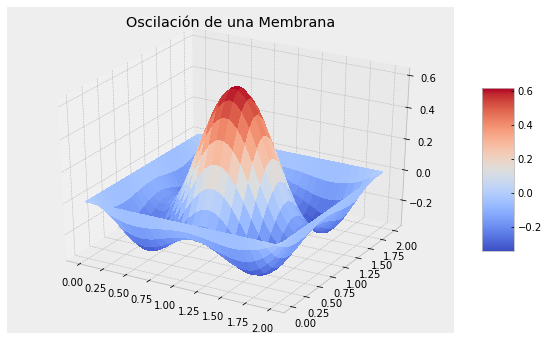

paso: 50.0 t= 1.4849999999999999


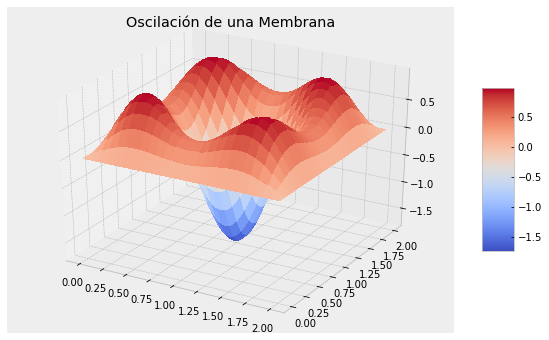

paso: 60.0 t= 1.785


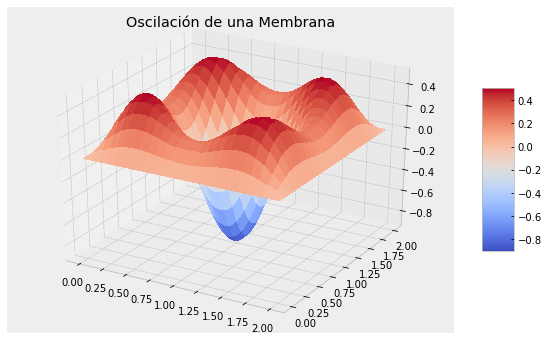

paso: 70.0 t= 2.085


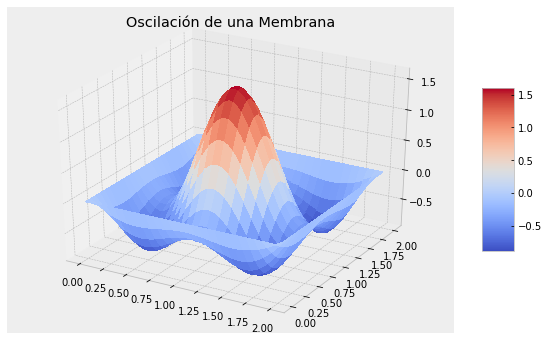

paso: 80.0 t= 2.385


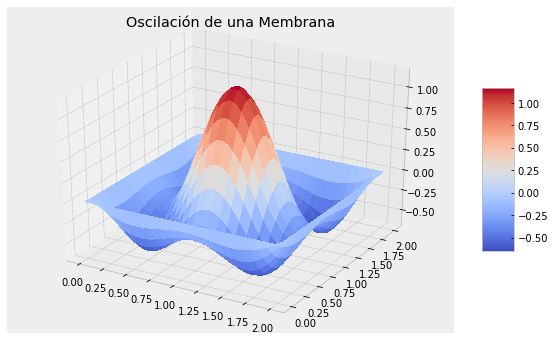

paso: 90.0 t= 2.685


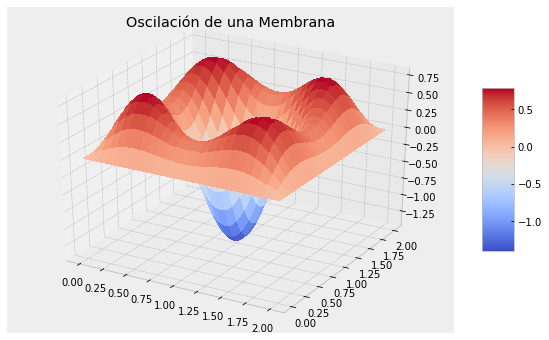

paso: 100.0 t= 2.985


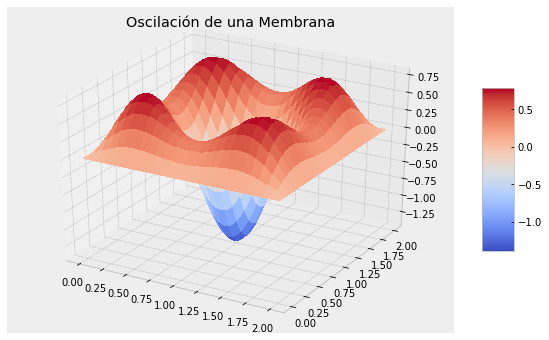

In [49]:
#!python 
#Solución de la Ecuación de Onda en 2D: Utt = (Uxx+Uyy)
# Método de Diferencias Finitas 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# Se define la Clase general que incluye todas las funciones
class WaveEquationFD:
    
    def __init__(self, N, D, Mx, My):
        self.N = N
        print('N:',N)
        self.D = D
        print('D:',D)
        self.Mx = Mx
        print('Mx:',Mx)
        self.My = My
        print('My',My)
        self.tend = 6
        self.xmin = 0
        self.xmax = 2
        self.ymin = 0
        self.ymax = 2
        self.initialization()
        self.eqnApprox()
           
    def initialization(self):
        self.dx = (self.xmax - self.xmin)/self.Mx
        self.dy = (self.ymax - self.ymin)/self.My
        print('dx,dy;',self.dx,self.dy)
        
        self.x = np.arange(self.xmin, self.xmax+self.dx, self.dx)
        self.y = np.arange(self.ymin, self.ymax+self.dy, self.dy)
        
        #----- Initial condition -----#
        self.u0 = lambda r, s: 0.1*(np.sin(3*np.pi*r/2)*np.sin(np.pi*s/2)+np.sin(np.pi*r/2)*np.sin(3*np.pi*s/2))
        
        #----- Initial velocity -----#
        self.v0 = lambda a, b: 0
        
        #----- Boundary conditions -----#
        self.bxyt = lambda left, right, time: 0
        
        self.dt = (self.tend - 0)/self.N
        self.t = np.arange(0, self.tend+self.dt/2, self.dt)
        
        # Assertion for the condition of r < 1, for stability
        r = 4*self.D*self.dt**2/(self.dx**2+self.dy**2);
        assert r < 1, "r is bigger than 1!"

            
    def eqnApprox(self):
        #----- Approximation equation properties -----#
        self.rx = self.D*self.dt**2/self.dx**2
        self.ry = self.D*self.dt**2/self.dy**2
        self.rxy1 = 1 - self.rx - self.ry 
        self.rxy2 = self.rxy1*2

        #----- Initialization matrix u for solution -----#
        self.u = np.zeros((self.Mx+1, self.My+1))
        self.ut = np.zeros((self.Mx+1, self.My+1))
        self.u_1 = self.u.copy()
        
        #----- Fills initial condition and initial velocity -----#
        for j in range(1, self.Mx):
            for i in range(1, self.My):
                self.u[i,j] = self.u0(self.x[i], self.y[j])
                self.ut[i,j] = self.v0(self.x[i], self.y[j])
        
    
    def solve_and_animate(self):
        
        u_2 = np.zeros((self.Mx+1, self.My+1))
        
        xx, yy = np.meshgrid(self.x, self.y)
         
        fig = plt.figure(figsize=(12,8))        
        ax = fig.add_subplot(111, projection='3d')
        #ax = plt.axes(projection ='3d')
        
        wframe = None
        
        k = 0
        nsteps = self.N
        print('nsteps:',nsteps)
        
        while k < nsteps:
            if wframe:
                ax.collections.remove(wframe)
                
            self.t = k*self.dt
            
            #----- Fills in boundary condition along y-axis (vertical, columns 0 and Mx) -----#
            for i in range(self.My+1):
                self.u[i, 0] = self.bxyt(self.x[0], self.y[i], self.t)
                self.u[i, self.Mx] = self.bxyt(self.x[self.Mx], self.y[i], self.t)
                
            for j in range(self.Mx+1):
                self.u[0, j] = self.bxyt(self.x[j], self.y[0], self.t)
                self.u[self.My, j] = self.bxyt(self.x[j], self.y[self.My], self.t)
                
            if k == 0:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = 0.5*(self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j])) \
                                + 0.5*(self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1])) \
                                + self.rxy1*self.u[i,j] + self.dt*self.ut[i,j]
            else:
                for j in range(1, self.My):
                    for i in range(1, self.Mx):
                        self.u[i,j] = self.rx*(self.u_1[i-1,j] + self.u_1[i+1,j]) \
                            + self.ry*(self.u_1[i,j-1] + self.u_1[i,j+1]) \
                            + self.rxy2*self.u[i,j] - u_2[i,j]
                            
            u_2 = self.u_1.copy()
            self.u_1 = self.u.copy()

            wframe = ax.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
            
            ax.set_xlim3d(0, 2.0)
            ax.set_ylim3d(0, 2.0)
            ax.set_zlim3d(-1.5, 1.5)
            
            ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0])
            ax.set_yticks([0, 0.5, 1.0, 1.5, 2.0])
            
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("U")
            
            plt.pause(0.05)
            k += 0.5
            
            # Sección añadida para hacer gráficas cada 15 pasos 
            if (k < 101 and k%10 == 0):
                print('paso:',k, 't=', self.t)
                # Creating figure
                fig2 = plt.figure(figsize =(10, 6))
                ax2 = plt.axes(projection ='3d')
                # Creating color map
                my_cmap = plt.get_cmap('coolwarm')
                # Creating plot
                surf = ax2.plot_surface(xx, yy, self.u, cmap=cm.coolwarm, linewidth=2, 
                    antialiased=False)
                fig.colorbar(surf, ax = ax2,
                    shrink = 0.5, aspect = 5)
                ax2.set_title('Oscilación de una Membrana')
                # show plot
                plt.show()

# Se definen los parámetros con los que se va a ejecutar el código     
# N pasos de integración, parámetro de estabilidad < 0.5, Num.Puntos x, Núm.Puntos y

def main():
    simulator = WaveEquationFD(200, 0.25, 50, 50)
    simulator.solve_and_animate() # No funcionó en Google Colab
    plt.show()
    
if __name__ == "__main__":
    main()